In [13]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely import wkt
import matplotlib.pyplot as plt

from utils.chrono import Chrono


# Loading

## Loading ZF
* GIS of EGT

In [14]:
zf = gpd.read_file('/Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/zf_map.csv')
zf['x'] = zf.centroid.x
zf['y'] = zf.centroid.y

## Loading depl
* **D3** : zf d'origine
* **D7** : zf de destination
* **D11** : distance à vol d'oiseau
* **MODP** : mode principal
    * **0** : pieds
    * **1** : vélo
    * **2** : voiture ou moto
    * **3** : transport en commun

In [15]:
depl = pd.read_csv('/Users/benoit/Desktop/Pro/210526-fusion/outdata/egt_lyon_pop_sample/depl.csv', sep=';',
                  dtype={'D3':str, 'D7':str, 'D4':str, 'D8':str, 'id_per':str})
depl.head()

,DP1,IDD3,IDD4,ZFD,NDEP,GD1,STD,D2A,D2B,D3,...,D10,D11,D12,MODP,TYPD,id_per,id_dep,origin_motive,destination_motive,hour
0,3,2015,69123,101001,1,69123,101,1,NaN,101001,...,1,1110,1665,3,1,00101001841,1010018411,0,4,10
1,3,2015,69123,101001,2,69123,101,42,NaN,102001,...,1,1110,1665,3,1,00101001841,1010018412,4,0,11
2,3,2015,69123,101001,1,69123,101,1,NaN,101001,...,1,2590,3885,3,1,00101001842,1010018421,0,1,8
3,3,2015,69123,101001,2,69123,101,11,NaN,104001,...,2,2750,4125,3,1,00101001842,1010018422,1,0,17
4,3,2015,69123,101001,1,69123,101,1,NaN,101001,...,1,2390,3585,3,1,00101001843,1010018431,0,2,7


## Loading iris_communes

In [16]:
iris_commune = gpd.read_file('/Users/benoit/Desktop/Pro/210526-fusion/outdata/census_pop_sample/census_gis_map.csv')
iris_commune['iris_or_commune'] = iris_commune['iris_or_commune'].astype(int)
iris_commune['x'] = iris_commune['x'].astype(float)
iris_commune['y'] = iris_commune['y'].astype(float)
iris_commune.head()

,iris_or_commune,frac_area,is_iris,x,y,nearest_neighbor_0,nearest_neighbor_1,nearest_neighbor_2,nearest_neighbor_3,nearest_neighbor_4,...,nearest_neighbor_12,nearest_neighbor_13,nearest_neighbor_14,nearest_neighbor_15,nearest_neighbor_16,nearest_neighbor_17,nearest_neighbor_18,nearest_neighbor_19,wkt,geometry
0,1043,1.0,False,3.932173e+06,2.538223e+06,692820201,692820103,692560101,692860101,692820203,...,692820601,01249,01276,01424,01262,01418,01049,01376,"POLYGON ((3931567.736276374 2535603.293954749,...","POLYGON ((3931567.736 2535603.294, 3931455.673..."
1,1049,0.903,False,3.934408e+06,2.538726e+06,692820103,692820201,01275,692750111,692820204,...,692820601,692790101,01424,01376,01418,01276,01043,01262,"POLYGON ((3931819.418597308 2541777.410917769,...","POLYGON ((3931819.419 2541777.411, 3931843.795..."
2,1249,0.901,False,3.927977e+06,2.538779e+06,692860102,69292,692860501,692860201,69033,...,692860302,01043,692860303,692860304,01424,692860101,01376,01275,"POLYGON ((3930627.132465467 2534580.112867319,...","POLYGON ((3930627.132 2534580.113, 3930588.941..."
3,1262,0.161,False,3.934404e+06,2.540983e+06,692820201,692820204,692820104,692860101,692750111,...,692790101,01249,01418,01276,01376,01424,01043,01049,"POLYGON ((3931728.803749514 2541776.576775731,...","POLYGON ((3931728.804 2541776.577, 3931683.836..."
4,1275,1.0,False,3.926872e+06,2.536284e+06,692560202,01376,692860501,692560302,692560301,...,01249,692860401,692860301,692560101,692860302,692860101,692860304,692860303,"POLYGON ((3926169.735135304 2534938.132562069,...","POLYGON ((3926169.735 2534938.133, 3926094.500..."


# Viz of depl wrt mode

In [17]:
print(len(depl))
depl_od = depl.merge(zf[['ZF2015_Nouveau_codage', 'x', 'y']], left_on='D3', right_on='ZF2015_Nouveau_codage')
depl_od = depl_od.rename(columns={'x':'ox', 'y':'oy'})
depl_od = depl_od.merge(zf[['ZF2015_Nouveau_codage', 'x', 'y']], left_on='D7', right_on='ZF2015_Nouveau_codage')
depl_od = depl_od.rename(columns={'x':'dx', 'y':'dy'})
print(len(depl_od))
# les zf sont filtrées pour la zone d'étude, on perd des trajets

99157
51396


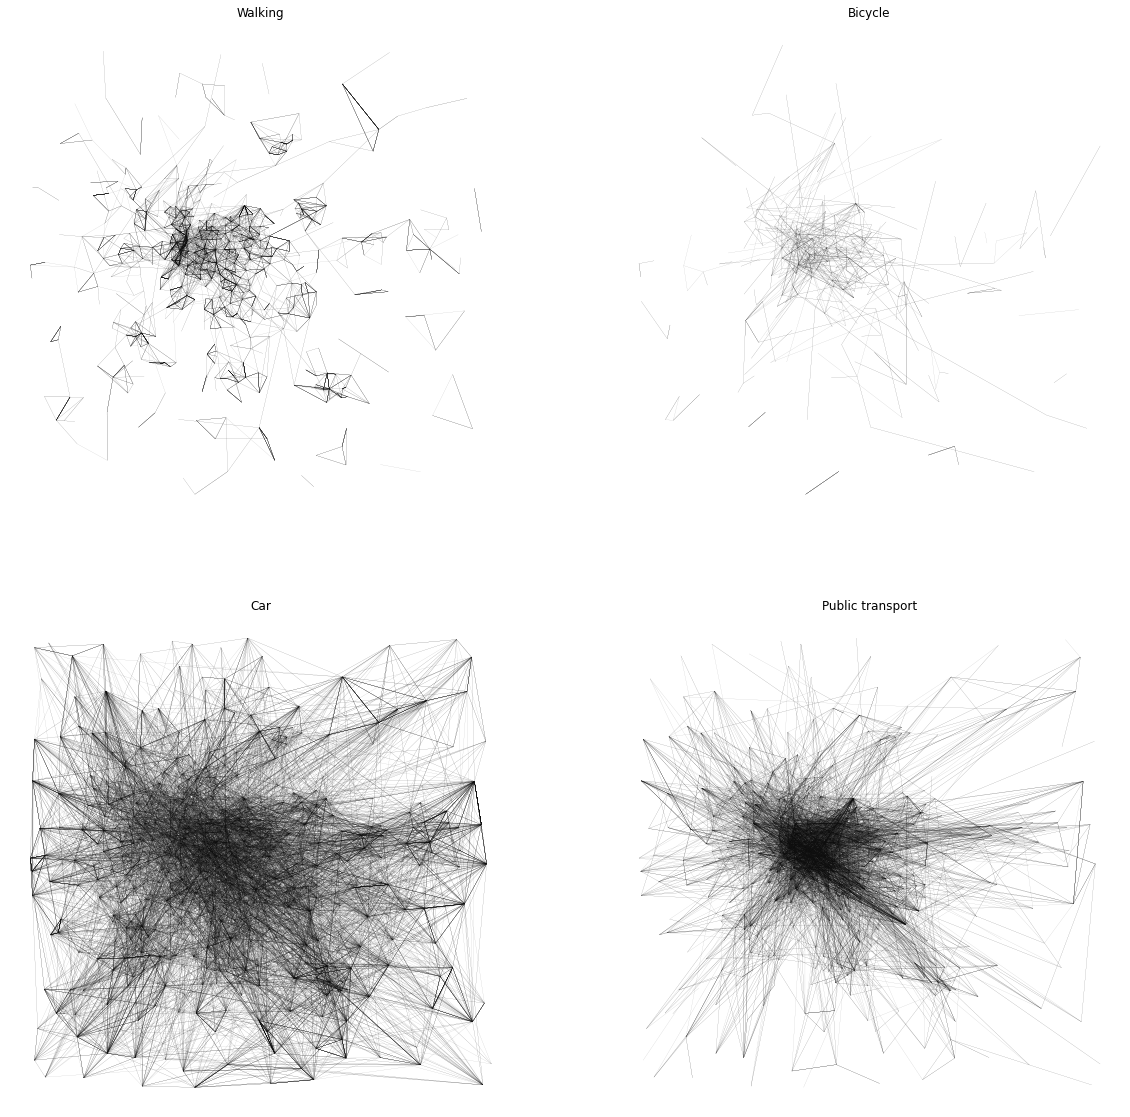

In [18]:
# 00:01:00
mod_dict = {0:'Walking', 1:'Bicycle', 2:'Car', 3:'Public transport'}

fig, axes = plt.subplots(2, 2, figsize = (20, 20))
for target_mod, ax in enumerate(axes.flatten()):

    oxs = depl_od[depl_od['MODP']==target_mod].ox
    oys = depl_od[depl_od['MODP']==target_mod].oy
    dxs = depl_od[depl_od['MODP']==target_mod].dx
    dys = depl_od[depl_od['MODP']==target_mod].dy
    ax.plot([oxs, dxs], [oys, dys], color='k', alpha=0.5, linewidth=0.1)
    ax.axis(False)
    ax.set_title(mod_dict[target_mod])
    
plt.show()


# Computing P(m | dist(o,d))

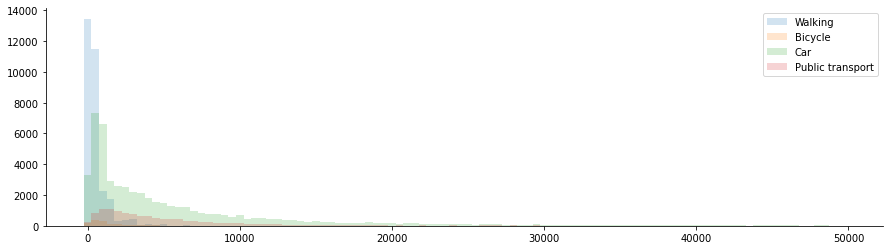

In [7]:
step = 500
thres = 50000
depl['dist_clipped'] = depl['D11'].clip(upper=thres)
xbins = np.arange(0, thres+step, step)
depl['dist_bin'] = pd.cut(depl['D11'], bins = xbins, labels=xbins[:-1])

fig, ax = plt.subplots(figsize=(15,4))
for i, mode in mod_dict.items():
    ax.bar(xbins[:-1], depl[depl['MODP']==i].groupby('dist_bin').size(), width=step, alpha=0.2, label=mode)
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)
ax.legend()
plt.show()

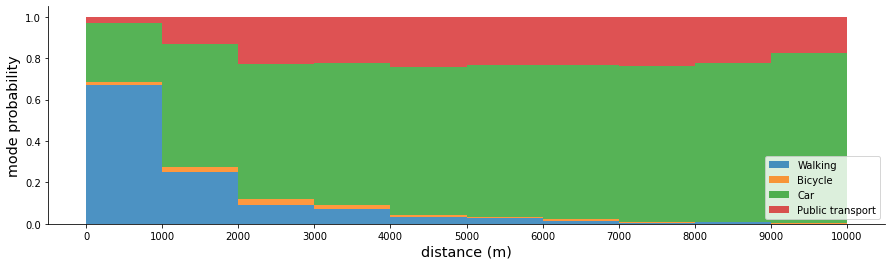

In [8]:
step = 1000
thres = 10000
xbins = np.arange(0, thres+step, step)


depl['dist_clipped'] = depl['D11'].clip(upper=thres)
depl['dist_bin'] = pd.cut(depl['dist_clipped'], bins = xbins, labels=xbins[:-1])
histdata = np.array([depl[depl['MODP']==i].groupby('dist_bin').size().values for i in range(4)])
histdata = histdata/histdata.sum(axis=0, keepdims=True)


fig, ax = plt.subplots(figsize=(15,4))
bottom = np.zeros(histdata.shape[1])
for i, mode in mod_dict.items():
    ax.bar(xbins[:-1], histdata[i], bottom=bottom, width=step, label=mode, alpha=0.8, align='edge')
    bottom += histdata[i]
ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

ax.set_xlabel('distance (m)', fontsize='x-large')
ax.set_ylabel('mode probability', fontsize='x-large')
ax.set_xticks(xbins, xbins)
ax.legend()
plt.show()

# Loading transition matrix

In [9]:
c = Chrono('Loading...')
transition_matrix = pd.read_csv('/Users/benoit/Desktop/Pro/210526-fusion/outdata/iris_Mod_unanon.csv')
timesteps = np.array([ 0.,  2.,  5.,  7.,  8.,  9., 10., 12., 14., 16., 17., 18., 19., 20., 22.])

c.tprint('Snapping the individual hours to timesteps...')
transition_matrix['t'] = timesteps[np.maximum(np.searchsorted(timesteps, transition_matrix['t'], side='right')-1, 0)]
transition_matrix = transition_matrix.groupby(['o','d','t']).sum().reset_index()

c.tprint('Getting flight distance o->d...')
transition_matrix = transition_matrix.merge(iris_commune[['iris_or_commune', 'x', 'y']], left_on='o', right_on='iris_or_commune')
transition_matrix = transition_matrix.rename(columns={'x':'ox', 'y':'oy'})
transition_matrix = transition_matrix.drop(columns='iris_or_commune')

transition_matrix = transition_matrix.merge(iris_commune[['iris_or_commune', 'x', 'y']], left_on='d', right_on='iris_or_commune')
transition_matrix = transition_matrix.rename(columns={'x':'dx', 'y':'dy'})
transition_matrix = transition_matrix.drop(columns='iris_or_commune')

transition_matrix['dist'] =np.sqrt((transition_matrix['ox']-transition_matrix['dx'])**2+
                                           (transition_matrix['oy']-transition_matrix['dy'])**2)
transition_matrix = transition_matrix.drop(columns=['ox', 'oy', 'dx', 'dy'])


step = 1000
thres = 10000
c.tprint('Binning distances in bins of {}m, clipping above {}m...'.format(step, thres))
xbins = np.arange(0, thres+step, step)
transition_matrix['dist'] = transition_matrix['dist'].clip(upper=thres)
transition_matrix['dist_bin'] = pd.cut(transition_matrix['dist'], bins=xbins, labels=xbins[:-1], include_lowest=True)

c.done()
transition_matrix.head()


12:11:49	Loading...
00:00:02	Snapping the individual hours to timesteps...
00:00:03	Getting P(d | o, t)...
00:00:04	Getting P(o | d, t)...
00:00:05	Getting flight distance o->d...
00:00:07	Binning distances in bins of 1000m, clipping above 10000m...
00:00:07	Work complete !


,o,d,t,vol,proba_d,proba_o,dist,dist_bin
0,1043,1043,0.0,9.132230,0.287785,0.205852,0.0,0
1,1043,1043,2.0,5.813602,0.271967,0.123532,0.0,0
2,1043,1043,5.0,17.833213,0.105533,0.124070,0.0,0
3,1043,1043,7.0,54.360548,0.193669,0.187093,0.0,0
4,1043,1043,8.0,29.113536,0.120248,0.102542,0.0,0


* Getting `proba_m_df`, proba of mode w.r.t. distance bin:

In [10]:
i = 0
proba_m_df = depl[depl['MODP']==i].groupby('dist_bin').size().reset_index().rename(columns=({0:'vol_mode_{}'.format(i)}))
for i in range(1, 4):
    proba_m_df = proba_m_df.merge(depl[depl['MODP']==i].groupby('dist_bin').size().reset_index().rename(columns=({0:'vol_mode_{}'.format(i)})),
                                  on='dist_bin')
    
proba_m_df['vol_tot'] = np.sum([proba_m_df['vol_mode_{}'.format(j)] for j in range(4)], axis=0)
for i in range(4):
    proba_m_df['vol_mode_{}'.format(i)] = proba_m_df['vol_mode_{}'.format(i)]/proba_m_df['vol_tot']
proba_m_df = proba_m_df.drop(columns='vol_tot')
proba_m_df.head()

,dist_bin,vol_mode_0,vol_mode_1,vol_mode_2,vol_mode_3
0,0,0.669030,0.015333,0.286286,0.029351
1,1000,0.248442,0.027923,0.590750,0.132885
2,2000,0.092943,0.024802,0.652007,0.230248
3,3000,0.071361,0.017486,0.687303,0.223850
4,4000,0.032666,0.011380,0.713172,0.242782


In [11]:
def get_transition_matrix_mode(mode):
    """
    get transition matrix assuming given mode
    """
    transition_matrix_mode = transition_matrix.merge(proba_m_df[['dist_bin', 'vol_mode_{}'.format(mode)]],
                                                             on='dist_bin')
    transition_matrix_mode['mode'] = mode
    transition_matrix_mode['proba_d'] = transition_matrix_mode['proba_d'] * transition_matrix_mode['vol_mode_{}'.format(mode)]
    transition_matrix_mode['proba_d'] = transition_matrix_mode['proba_d']/transition_matrix_mode.groupby(['o','t','mode'])['proba_d'].transform(sum)
    
    transition_matrix_mode['proba_o'] = transition_matrix_mode['proba_o'] * transition_matrix_mode['vol_mode_{}'.format(mode)]
    transition_matrix_mode['proba_o'] = transition_matrix_mode['proba_o']/transition_matrix_mode.groupby(['d','t','mode'])['proba_o'].transform(sum)

    transition_matrix_mode['vol'] = transition_matrix_mode['vol'] * transition_matrix_mode['vol_mode_{}'.format(mode)]
    transition_matrix_mode = transition_matrix_mode.drop(columns=['dist','dist_bin','vol_mode_{}'.format(mode)])
    return transition_matrix_mode

transition_matrix_otm = pd.concat([get_transition_matrix_mode(mode) for mode in range(4)])


# Exporting

In [12]:
transition_matrix_otm.to_csv('/Users/benoit/Desktop/Pro/210526-fusion/outdata/trans_matrix_by_mode.csv', index=False)

# Reading example
import pandas as pd
transition_matrix_otm = pd.read_csv('/Users/benoit/Desktop/Pro/210526-fusion/outdata/trans_matrix_by_mode.csv')
transition_matrix_otm.head()

,o,d,t,vol,proba_d,proba_o,mode
0,1043,1043,0.0,6.109734,0.800645,0.875372,0
1,1043,1043,2.0,3.889473,0.873112,0.851645,0
2,1043,1043,5.0,11.930950,0.806792,0.873712,0
3,1043,1043,7.0,36.368826,0.871450,0.876207,0
4,1043,1043,8.0,19.477823,0.787669,0.819090,0
